In [1]:
# %%
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('activation_diff_results_inverse_transform.csv')


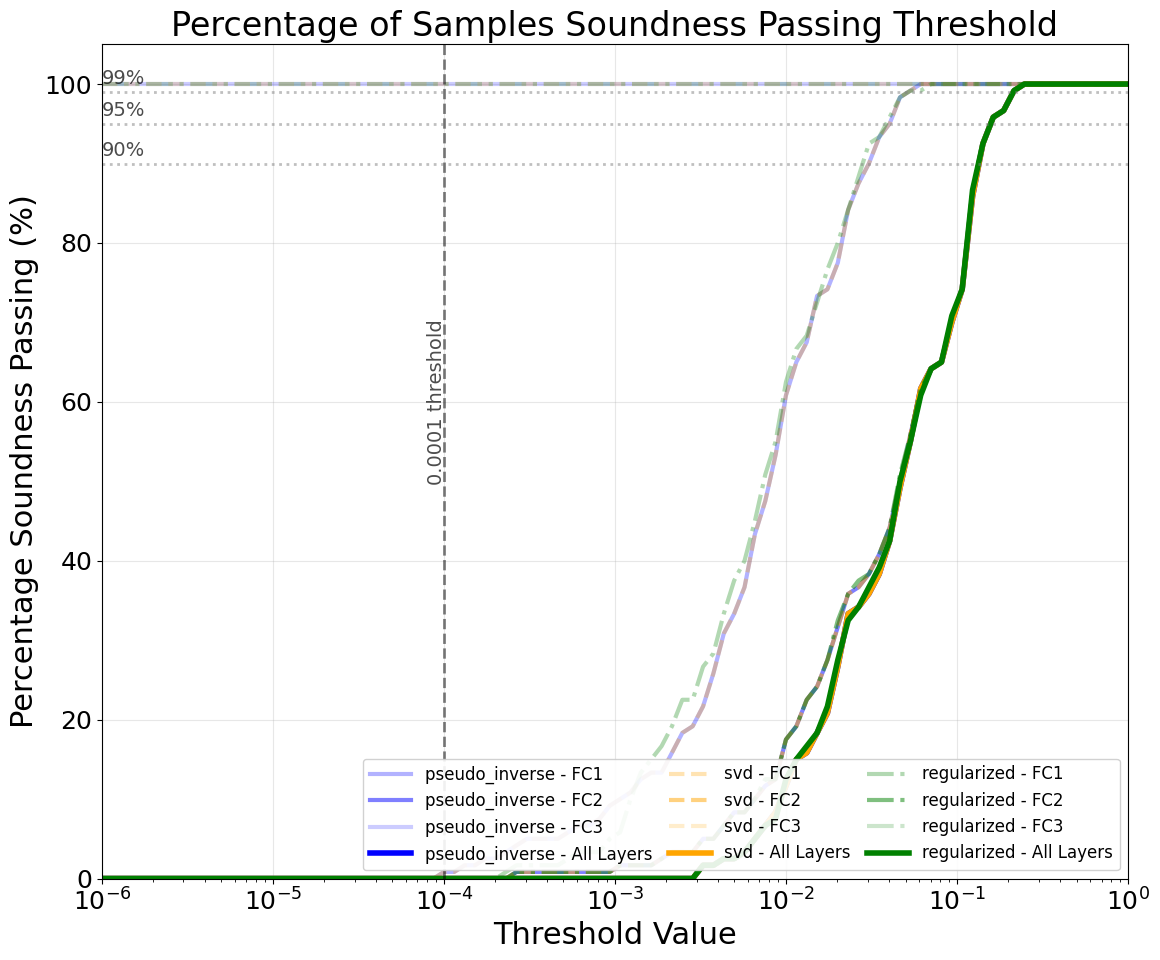


Percentage passing at key thresholds:

Threshold = 0.0001:
--------------------------------------------------

pseudo_inverse:
  FC1: 0.8%
  FC2: 0.0%
  FC3: 100.0%
  All Layers: 0.0%

svd:
  FC1: 0.8%
  FC2: 0.0%
  FC3: 100.0%
  All Layers: 0.0%

regularized:
  FC1: 0.0%
  FC2: 0.0%
  FC3: 100.0%
  All Layers: 0.0%

Threshold = 0.001:
--------------------------------------------------

pseudo_inverse:
  FC1: 9.2%
  FC2: 1.7%
  FC3: 100.0%
  All Layers: 0.0%

svd:
  FC1: 9.2%
  FC2: 1.7%
  FC3: 100.0%
  All Layers: 0.0%

regularized:
  FC1: 5.0%
  FC2: 1.7%
  FC3: 100.0%
  All Layers: 0.0%

Threshold = 0.01:
--------------------------------------------------

pseudo_inverse:
  FC1: 60.8%
  FC2: 17.5%
  FC3: 100.0%
  All Layers: 11.7%

svd:
  FC1: 60.8%
  FC2: 17.5%
  FC3: 100.0%
  All Layers: 11.7%

regularized:
  FC1: 62.5%
  FC2: 17.5%
  FC3: 100.0%
  All Layers: 12.5%

Threshold = 0.1:
--------------------------------------------------

pseudo_inverse:
  FC1: 100.0%
  FC2: 73.3%
  

In [28]:
# Set global font size
plt.rcParams.update({'font.size': 20})

# Define threshold values to test
thresholds = np.logspace(-6, 0, 100)  # From 1e-6 to 1 (0.000001 to 1)

# Create single plot figure
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Define methods and layers
methods = ['pseudo_inverse', 'svd', 'regularized']
layers = ['fc1', 'fc2', 'fc3']

# Define colors and styles for each method
method_styles = {
    'pseudo_inverse': {'color': 'blue', 'linestyle': '-'},
    'svd': {'color': 'orange', 'linestyle': '--'},
    'regularized': {'color': 'green', 'linestyle': '-.'}
}

# Define layer alphas for visual distinction
layer_alphas = {'fc1': 0.3, 'fc2': 0.5, 'fc3': 0.2}

# Iterate over all methods
for method in methods:
    # Group by method
    method_data = df[df['inverse_method'] == method]
    
    # Plot minimum values for each layer
    for layer in layers:
        column = f'{layer}_min_abs_diff'
        values = method_data[column].values
        
        # Calculate percentage passing each threshold
        percentages = []
        for threshold in thresholds:
            passing = np.sum(values <= threshold) / len(values) * 100
            percentages.append(passing)
        
        # Plot cumulative distribution
        ax.semilogx(thresholds, percentages, 
                   label=f'{method} - {layer.upper()}',
                   color=method_styles[method]['color'],
                   linestyle=method_styles[method]['linestyle'],
                   linewidth=3, 
                   alpha=layer_alphas[layer])
    
    # Plot the all-layers maximum for this method (worst case - ALL layers must pass)
    percentages_all = []
    for threshold in thresholds:
        passing_count = 0
        for idx in method_data.index:
            row = method_data.loc[idx]
            # Check if all layers pass for this sample
            all_pass = True
            for layer in layers:
                if row[f'{layer}_min_abs_diff'] > threshold:
                    all_pass = False
                    break
            if all_pass:
                passing_count += 1
        
        percentage = (passing_count / len(method_data)) * 100
        percentages_all.append(percentage)
    
    ax.semilogx(thresholds, percentages_all, 
               label=f'{method} - All Layers',
               color=method_styles[method]['color'],
               linewidth=4,
               alpha=1.0)

# Add reference lines
ax.axvline(x=0.0001, color='black', linestyle='--', alpha=0.5, linewidth=2)
ax.axhline(y=90, color='gray', linestyle=':', alpha=0.5, linewidth=2)
ax.axhline(y=95, color='gray', linestyle=':', alpha=0.5, linewidth=2)
ax.axhline(y=99, color='gray', linestyle=':', alpha=0.5, linewidth=2)

# Add text labels
ax.text(0.00008, 50, '0.0001 threshold', rotation=90, fontsize=14, alpha=0.7)
ax.text(1e-6, 91, '90%', fontsize=14, alpha=0.7)
ax.text(1e-6, 96, '95%', fontsize=14, alpha=0.7)
ax.text(1e-6, 100, '99%', fontsize=14, alpha=0.7)

ax.set_xlabel('Threshold Value', fontsize=22)
ax.set_ylabel('Percentage Soundness Passing (%)', fontsize=22)
ax.set_title('Percentage of Samples Soundness Passing Threshold', fontsize=24)

# Create legend with 4 rows and 3 columns
ax.legend(fontsize=12, 
          loc='lower right', 
          ncol=3,  # 3 columns
          columnspacing=1.0,
          handlelength=2.5,
          framealpha=0.9)

ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
ax.set_xlim(1e-6, 1)
ax.tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout()
plt.savefig('cumulative_threshold_all_methods_grouped.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics at key thresholds
print("\nPercentage passing at key thresholds:")
print("=" * 70)
key_thresholds = [0.0001, 0.001, 0.01, 0.1]

for threshold in key_thresholds:
    print(f"\nThreshold = {threshold}:")
    print("-" * 50)
    
    for method in methods:
        method_data = df[df['inverse_method'] == method]
        print(f"\n{method}:")
        
        for layer in layers:
            column = f'{layer}_min_abs_diff'
            values = method_data[column].values
            percentage = np.sum(values <= threshold) / len(values) * 100
            print(f"  {layer.upper()}: {percentage:.1f}%")
        
        # All layers simultaneous
        passing_count = 0
        for idx in method_data.index:
            row = method_data.loc[idx]
            all_pass = all(row[f'{layer}_min_abs_diff'] <= threshold for layer in layers)
            if all_pass:
                passing_count += 1
        percentage = (passing_count / len(method_data)) * 100
        print(f"  All Layers: {percentage:.1f}%")
